\noindent __Erwann Rault__  
_Centre Oscar Lambret (Lille)_

In [1]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook

In [2]:
# LIBRARIES #

import numpy as np
import pydicom as dcm
import matplotlib.pyplot as plt
import math
import time
import datetime

from scipy import ndimage
from ipywidgets import *
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from os.path import basename

import warnings
warnings.filterwarnings('ignore')

In [50]:
# INPUT VARIABLES #

#fileDialog = QtGui.QFileDialog()
#filepath = fileDialog.getOpenFileName()
filepath = 'ACLIN1.col.9f3b.fr.col.S1.2965012.1_00000.DCM'

Ainj = 36.40 #MBq
Tinj = datetime.datetime(2019,3,14,11,30,0)

Ares = 0.0 #MBq
Tres = datetime.datetime(2019,3,14,11,30,0)

img_index = 0
scimg_index = 2

# CSTES #
nb_detectors = 2 #fausse valeur dans dicom header (reconstruction?)
isotopeName = "Tc99m"
T1demi = 13.22 #I131:192.48 Tc:6.058 I123:13.22 hours, half life from the isotope
margeROI = 3 #pix

# Acquisition information

In [51]:
# READS THE DICOM FILE #

ds = dcm.read_file(filepath)

In [52]:
# CONVERT DICOM TIME INFO TO DATETIME #

def convertToDatetime(date, time):
    year = int(int(date)/10000)
    month = int(int(date)/100-year*100)
    day = int(int(date)-year*10000-month*100)
    hour = int(float(time)/10000)
    minute = int(float(time)/100-hour*100)
    seconds =  int(float(time)-minute*100-hour*10000)
    return datetime.datetime(year, month, day, hour, minute, seconds)

In [53]:
# GET RELEVANT INFORMATION FROM DICOM FILE #

patient_name = ds.PatientName

study_date = ds.StudyDate
scan_time = ds[0x0008,0x0033].value
acq_datetime = convertToDatetime(study_date,scan_time)

try:
    rescaleIntercept = ds[0x0028,0x1052].value
    rescaleSlope = ds[0x0028,0x1053].value
except KeyError:
    rescaleIntercept = 0
    rescaleSlope = 1
    
nb_pixel_x = ds[0x0028,0x0011].value
nb_pixel_y = ds[0x0028,0x0010].value
nb_energy_win = ds.NumberOfEnergyWindows
frame_duration = int(ds[0x0018,0x1242].value/1000)

print("Patient name: ", patient_name)
print("Patient ID: ", ds[0x0020,0x0010].value)
print("File name:", basename(filepath))
print(" ")
print("Injected Isotope: ", isotopeName, "(half life:", T1demi,"h)")
print("Injected activity: ", Ainj, " MBq @ ", Tinj)
print("Residual activity: ", Ares, " MBq @ ", Tres)
print(" ")
print("Scan date and time: ", acq_datetime)
print("Nb of energy windows: " + str(nb_energy_win))
print("Nb of detectors: " + str(nb_detectors))
print("Image size: {0} x {1}" .\
                format(nb_pixel_x, nb_pixel_y))
print("Acquisition time: ", frame_duration, "s")
print("Rescale slope:", rescaleSlope)
print("Rescale intercept:", rescaleIntercept)
print(" ")
print("Camera: ", ds[0x0008,0x0070].value)
print("        ", ds[0x0008,0x1010].value)
print("Collimator name: ", ds[0x0054,0x0022][0][0x0018,0x1180].value)
print("Collimator type: ", ds[0x0054,0x0022][0][0x0018,0x1181].value)
print("Zoom factor: ", ds[0x0054,0x0022][0][0x0028,0x0031].value)

Patient name:  ZZZ-QUANTIF
Patient ID:  MIBG I 123
File name: ACLIN1.col.9f3b.fr.col.S1.2965012.1_00000.DCM
 
Injected Isotope:  Tc99m (half life: 13.22 h)
Injected activity:  36.4  MBq @  2019-03-14 11:30:00
Residual activity:  0.0  MBq @  2019-03-14 11:30:00
 
Scan date and time:  2019-03-14 18:02:34
Nb of energy windows: 3
Nb of detectors: 2
Image size: 128 x 128
Acquisition time:  600 s
Rescale slope: 1
Rescale intercept: 0
 
Camera:  GE MEDICAL SYSTEMS
         Discovery NM/CT
Collimator name:  MEGP
Collimator type:  PARA
Zoom factor:  ['1.000000', '1.000000']


In [54]:
# ENERGY WINDOWS #

#print ds[0x0054,0x0012][0]
#print ds[0x0054,0x0012][1]

# inline function to compute the energy mean and width of the energy windows (lambda function)
mk_energy_dict = lambda x,y:[(x+y)/2, round(np.abs(float(x)-float(y)),2)]

# creation of the dictionary
energy_list = list()
for el in range(nb_energy_win):
    energy_list.append(
        (mk_energy_dict(
            ds[0x0054,0x0012][el][0x0054,0x0013][0][0x0054,0x0014].value, 
            ds[0x0054,0x0012][el][0x0054,0x0013][0][0x0054,0x0015].value),el)
    )

print(" Energy windows found:")
for i in energy_list:    
    print("   -> ", i)

 Energy windows found:
   ->  ([159.0, 31.8], 0)
   ->  ([185.0, 18.5], 1)
   ->  ([135.0, 13.5], 2)


In [55]:
# TRIPLE ENERGY WINDOW CORRECTION #

# Triple energy window correction
def tew_corr(img0, w0, img1, w1, img2, w2):
    return img0 - ((img1/w1+img2/w2)*w0/2)

# Triple energy window correction (with only one scatter image)
def tew_oneScatterImg(img0, w0, img1, w1):
    return img0 - (img1/w1*w0/2)

# gets rid of negative values
def zeroify(image):
    for n, val in enumerate(image.flat):
        if val < 0:
            image.flat[n] = 0
    return image        

# Does the job
if (len(energy_list)==1):
    m_img = ds.pixel_array[:,:].astype(np.float32)
elif (len(energy_list)==2):
    w0 = energy_list[1][0].values()[0]
    w1 = energy_list[0][0].values()[0]
    m_img = ds.pixel_array[img_index,:,:].astype(np.float32) * rescaleSlope + rescaleIntercept
    m_scatterimg = ds.pixel_array[scimg_index,:,:].astype(np.float32) * rescaleSlope + rescaleIntercept
    m_tewimg = zeroify(tew_oneScatterImg(m_img, w0, m_scatterimg, w1))
elif (len(energy_list)==3): # pas encore vérifié
    w0 = energy_list[0][0][1]
    w1 = energy_list[1][0][1]
    w2 = energy_list[2][0][1]
    m_img = ds.pixel_array[0,:,:].astype(np.float32)
    m_scatterimg1 = ds.pixel_array[1,:,:].astype(np.float32)
    m_scatterimg2 = ds.pixel_array[2,:,:].astype(np.float32)
    m_tewimg = zeroify(tew_corr(m_img, w0, m_scatterimg1, w1, m_scatterimg2, w2))
else:
    print('Image format not supported.')
    

# SUV Calibration factor

In [56]:
# LAYOUT DEFINITIONS #

box_layout_std = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-start',
                    width='100%')

box_layout_right = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-end',
                    border='solid 0.5px #EEE',
                    width='100%')


In [57]:
# FINDS THE SUV PHANTOM IN THE IMAGE #

# function to find the phantom dimension and center in the image
def findPhantom(img, dimx, dimy):
    com = ndimage.measurements.center_of_mass(img)
    comx = int(com[0])
    maxx = ndimage.measurements.maximum(img[comx,:])
    x1 = 0
    while (img[comx,x1]<maxx/5):
        x1 = x1+1
    x2 = dimx-1
    while (img[comx,x2]<maxx/5):
        x2 = x2-1
    x1=x1-1
    x2=x2+1
    comy = int(com[1])
    maxy = ndimage.measurements.maximum(img[:,comy])
    y1 = 0
    while (img[y1,comy]<maxy/5):
        y1 = y1+1
    y2 = dimy-1
    while (img[y2,comy]<maxy/5):
        y2 = y2-1
    y1=y1-1
    y2=y2+1
    centerx = int(x1+(x2-x1)/2)
    centery = int(y1+(y2-y1)/2)
    if ((y2-y1)>(x2-1)):
        radius =(y2-y1)/2
    else:
        radius = (x2-x1)/2
    return [centerx, centery, radius]


In [58]:
# FUNCTION TO CALC THE NB OF COUNTS IN THE IMAGE INSIDE THE ROI #

def calc_nbOfCounts(img, dimx, dimy, centerx, centery, r):
    nbcnts = 0
    for j in range(0, dimy):
        for i in range(0, dimx):
            if (math.sqrt((i-centerx)*(i-centerx)+(j-centery)*(j-centery))<=r):
                nbcnts = nbcnts + img[j,i]
    return nbcnts

In [59]:
# SUV FACTOR CALCULATION #

def calcSUVfactor(nbcnts, a0, t0, ares, tres, tscan, duration, T):
    t = (tscan - t0).total_seconds()/3600.0
    A = a0 * math.exp(-t*math.log(2)/T)
    t = (tscan - tres).total_seconds()/3600.0
    B = ares * math.exp(-t*math.log(2)/T)
    s = float(nbcnts)/float(A-B)/float(duration)
    #print 'Activity in Petri box during acquisition:', str(round(A-B,2)), 'MBq'
    return s

Box(children=(Label(value='Visualization window:'), FloatSlider(value=0.0, description='min', max=5845.0, step…

Box(children=(Button(description='Refresh!', style=ButtonStyle()),), layout=Layout(border='solid 0.5px #EEE', …

Non corrected image:
  - Nb of counts in the image: 1154221
  - Delay between injection and scan:  6.54  hours
  - Calculated SUV factor:  74.48  cps/MBq
                            165.34  cpm/uCi
 
Triple Energy Window corrected Image:
  - Nb of counts in the image: 1012915
  - Delay between injection and scan:  6.54  hours
  - Calculated SUV factor:  65.36  cps/MBq
                            145.1  cpm/uCi


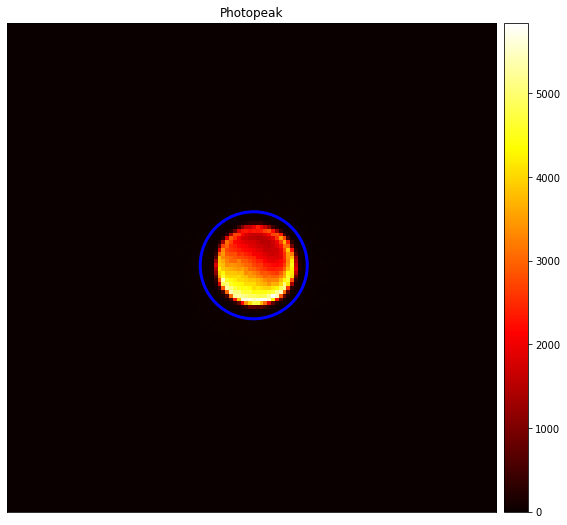

In [60]:
# MAIN INTERFACE #


# Displays SUV calculation results
def dispResults():
    if (len(energy_list)==1):
        nbcnts = calc_nbOfCounts(m_img, nb_pixel_x, nb_pixel_y, 
                             centerxslider.value, centeryslider.value, radiusslider.value)
        suvFactor = calcSUVfactor(nbcnts, Ainj, Tinj, Ares, Tres, acq_datetime, 
                              frame_duration, T1demi)
        print('Non corrected image:')
        print('  - Nb of counts in the image: ' + str(int(nbcnts)))
        print('  - Delay between injection and scan: ', round((acq_datetime-Tinj).total_seconds()/3600.0, 2), ' hours')
        print('  - Calculated SUV factor: ', str(round(suvFactor,2)), ' cps/MBq')
        print('                           ', str(round(suvFactor*2.22,2)), ' cpm/uCi')
    else:
        nbcnts = calc_nbOfCounts(m_img, nb_pixel_x, nb_pixel_y, 
                             centerxslider.value, centeryslider.value, radiusslider.value)
        nbcntsTEW = calc_nbOfCounts(m_tewimg, nb_pixel_x, nb_pixel_y, 
                             centerxslider.value, centeryslider.value, radiusslider.value)
        suvFactor = calcSUVfactor(nbcnts, Ainj, Tinj, Ares, Tres, acq_datetime, 
                              frame_duration, T1demi)
        suvFactorTEW = calcSUVfactor(nbcntsTEW, Ainj, Tinj, Ares, Tres, acq_datetime, 
                              frame_duration, T1demi)
        print('Non corrected image:')
        print('  - Nb of counts in the image: ' + str(int(nbcnts)))
        print('  - Delay between injection and scan: ', round((acq_datetime-Tinj).total_seconds()/3600.0, 2), ' hours')
        print('  - Calculated SUV factor: ', str(round(suvFactor,2)), ' cps/MBq')
        print('                           ', str(round(suvFactor*2.22,2)), ' cpm/uCi')
        print(' ')
        print('Triple Energy Window corrected Image:')
        print('  - Nb of counts in the image: ' + str(int(nbcntsTEW)))
        print('  - Delay between injection and scan: ', round((acq_datetime-Tinj).total_seconds()/3600.0, 2), ' hours')
        print('  - Calculated SUV factor: ', str(round(suvFactorTEW,2)), ' cps/MBq')
        print('                           ', str(round(suvFactorTEW*2.22,2)), ' cpm/uCi')

        
    # function to plot and update the images
def updatePlot(b):
    minv = minslider.value
    maxv = maxslider.value
    if (minv>maxv):
        print("Erreur: min > max")
    else:
        pltarray.imshow(m_img, cmap="hot", vmin = minv, vmax = maxv)
        c1.center = (centerxslider.value,centeryslider.value)
        c1.radius = radiusslider.value
        display.clear_output(wait=True)
        display.display(f)
        dispResults()

# Plot size
plt.rcParams['figure.figsize'] = (18,9)

# min, max of main image:
_min, _max = np.amin(m_img), np.amax(m_img)

# 2 sliders to change visualization:
minslider  = FloatSlider(value=_min, min=_min, max=_max, step=(_max-_min)/100, description='min', width='40%')
maxslider  = FloatSlider(value=_max, min=_min, max=_max, step=(_max-_min)/100, description='max', width='40%')

centerxslider = IntSlider(value=int(nb_pixel_x/2), min=0, max=nb_pixel_x, step=1, description="centerx",width='40%')
centeryslider = IntSlider(value=int(nb_pixel_y/2), min=0, max=nb_pixel_y, step=1, description="centery",width='40%')
radiusslider = IntSlider(value=2, min=0, max=int(nb_pixel_y/2), step=1, description="radius",width='40%')

refresh_button = Button(description="Refresh!", width='40%')
refresh_button.on_click(updatePlot)

items1 = [
    Label(value="Visualization window:", width='90%'),
    minslider,
    maxslider,
    Label(value=". ", width='90%'),
    Label(value="Region Of Interest:", width='90%'),
    centerxslider,
    centeryslider,
    radiusslider,
    Label(value=". ", width='90%'),
 ]
items2 = [
    refresh_button,
 ]

box1 = Box(children=items1, layout=box_layout_std)
box2 = Box(children=items2, layout=box_layout_right)
display.display(box1)
display.display(box2)

# Plots the images:
f, pltarray = plt.subplots(1,1)

im1 = pltarray.imshow(m_img, cmap="hot", vmin = _min, vmax = _max) #available cmaps: hot, gray, bone
pltarray.set_title('Photopeak')
pltarray.axes.get_xaxis().set_visible(False)
pltarray.axes.get_yaxis().set_visible(False)

roi = findPhantom(m_img, nb_pixel_x, nb_pixel_y)
centerxslider.value = roi[0]
centeryslider.value = roi[1]
radiusslider.value = roi[2] + margeROI

try:
    divider1 = make_axes_locatable(pltarray)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax1)

    c1 = plt.Circle((centerxslider.value, centeryslider.value), radiusslider.value, fill=False, color='blue', linewidth=3)
    pltarray.axes.add_patch(c1)
except:
    print('Erreur!')

dispResults()


# Remarks: